In [181]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

In [182]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [88]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'

spectrograms, labels = fe.extract_spectrograms(dataset_filename)
#if new_feats or not os.path.isfile(pickle_filename):
 #   spectrograms, labels = fe.extract_spectrograms(dataset_filename)
  #  with open(pickle_filename, 'wb') as f:
   #     pickle.dump([feats, labels], f)
#else:
 #   with open(pickle_filename, 'rb') as f:
  #      feats, labels = pickle.load(f)
   # print(f'{feats.shape[0]} features extracted')

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000


In [89]:
scaler = StandardScaler()
#scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(spectrograms, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

600 training samples
200 validation samples
200 test samples


In [184]:
np.shape(spectrograms[0])

(640, 128)

In [ ]:
#Input = (N,Cin,Lin) 
    #N = batch size
    #Cin = Channels (np.shape(spectrograms[0])[0])
    #Lin = np.shape(spectrograms[0])[1]
#Lout = ((Lin + 2*padding -dilation*(kernel_size-1)-1)/stride) + 1

In [ ]:
## class CNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1d1 = nn.Conv1d(input_size, hidden_size[0], kernel_size) #128-4=124
        self.conv1d1_bn = nn.BatchNorm1d(n_features[0], momentum=0.9) 
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2) #124/2 = 62
        self.dropout1 = nn.Dropout(0.5)
        
        self.conv1d2 = nn.Conv1d(hidden_size[0], hidden_size[1], kernel_size) #62-4 = 58 
        self.conv1d2_bn = nn.BatchNorm1d(n_features[1], momentum=0.9)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2) #58/2=29
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv1d3 = nn.Conv1d(hidden_size[1], hidden_size[2], kernel_size) #29-4=25
        self.conv1d3_bn = nn.BatchNorm1d(n_features[2], momentum=0.9)
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2) #25/2=12,5
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc = nn.Linear(hidden_size[2]*12, num_classes)
        
    
    def forward(self, x):
        #order: conv, batchnorm, activation, maxpool, drop
        #Calls:
        #Convolution 1d: out = F.relu(self.conv1d1(x))
        #Batch           normalization: out = self.conv1d1_bn(out)
        #Dropout:        out = self.dropout1(out)
        #Max Pooling:    out = self.pool1(out)
        
        #Layer1
        out = F.relu(self.conv1d1_bn(self.conv1d1(x)))
        out = self.pool1(out)
        out = self.dropout1(out)
        
        #Layer2
        out = F.relu(self.conv1d2_bn(self.conv1d2(out)))
        out = self.pool2(out)
        out = self.dropout2(out)
        
        #Layer3
        out = F.relu(self.conv1d3_bn(self.conv1d3(out)))
        out = self.pool3(out)
        out = self.dropout3(out)
        
        #TimeDistributed
        
        
        #Time_distributed_merge_layer
        
        #Flatten
        out = out.view(out.shape[0], -1)
        
        #Softmax
        out = self.fc(out)
        
        return out # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy
    

#model = CNNClassifier(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [202]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{(i+1)*len(data)}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [203]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [207]:
# Hyperparameters
input_size = 640
hidden_size = [256, 128, 64]
num_classes = 10
n_features = [256, 128, 64] #Get from xtrain (see BatchNorm1d)
kernel_size = 5
train_batch_size = 100
valid_batch_size = 100

num_epochs = 100
learning_rate = 0.0001

In [208]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = CNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(2, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [200/600 (33%)]	Loss: 2.397655
Train Epoch: 1 [400/600 (66%)]	Loss: 2.34733
Train Epoch: 1 [600/600 (100%)]	Loss: 2.317587

Validation set: Average loss: 2.2709, Accuracy: 27/200 (13%)

Train Epoch: 2 [200/600 (33%)]	Loss: 2.354433
Train Epoch: 2 [400/600 (66%)]	Loss: 2.33713
Train Epoch: 2 [600/600 (100%)]	Loss: 2.189313

Validation set: Average loss: 2.2497, Accuracy: 37/200 (18%)

Train Epoch: 3 [200/600 (33%)]	Loss: 2.282757
Train Epoch: 3 [400/600 (66%)]	Loss: 2.214276
Train Epoch: 3 [600/600 (100%)]	Loss: 2.206741

Validation set: Average loss: 2.2338, Accuracy: 41/200 (20%)

Train Epoch: 4 [200/600 (33%)]	Loss: 2.24513
Train Epoch: 4 [400/600 (66%)]	Loss: 2.205377
Train Epoch: 4 [600/600 (100%)]	Loss: 2.158626

Validation set: Average loss: 2.2184, Accuracy: 40/200 (20%)

Train Epoch: 5 [200/600 (33%)]	Loss: 2.193201
Train Epoch: 5 [400/600 (66%)]	Loss: 2.216498
Train Epoch: 5 [600/600 (100%)]	Loss: 2.093777

Validation set: Average loss: 2.2048, Accuracy: 40/200 

KeyboardInterrupt: 

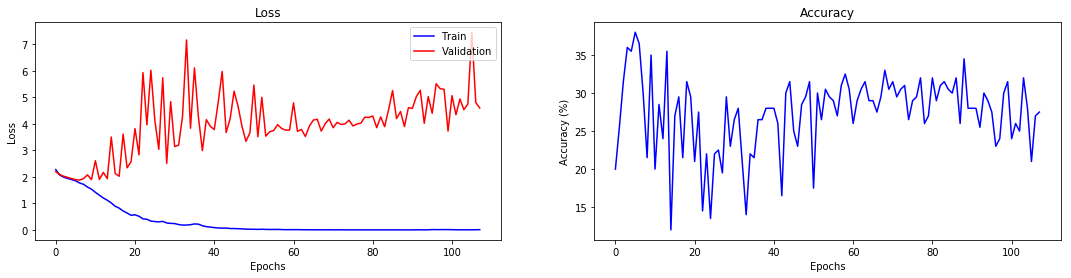

In [205]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()